# Branches for parallel node execution

The notebook [‘parallelization.ipynb’](https://github.com/langchain-ai/langchain-academy/blob/main/module-4/parallelization.ipynb) from module 4 of the LangGraph course in LangChain Academy indicates that when executing parallel paths of varying lengths, the graph should wait for all parallel steps to complete before advancing to the next step. This behavior is also described in the [example](https://langchain-ai.github.io/langgraph/how-tos/branching/#parallel-node-fan-out-and-fan-in-with-extra-steps) in the How-to-Guide.

However, the example below illustrates a different behavior.

In [1]:
from langgraph.graph import StateGraph, END, START
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated, TypedDict
from operator import add
from IPython.display import Image, display

In [2]:
class OverallState(TypedDict):
    a: Annotated[list[str], add]
    b: Annotated[list[str], add]
    c: Annotated[list[str], add]
    d: Annotated[list[str], add]
    e: Annotated[list[str], add]

In [3]:
workflow = StateGraph(OverallState)

# add nodes
workflow.add_node("A", lambda _:  {'a': ["I am A"]})
workflow.add_node("B", lambda _:  {'b': ["I am B"]})
workflow.add_node("C", lambda _:  {'c': ["I am C"]})
workflow.add_node("D", lambda _: {'d': ["I am D"]})
workflow.add_node("E", lambda state: {'e': [*state['c'], *state['d']]})

# add edges
workflow.add_edge(START, 'A')
workflow.add_edge('A', 'B')
workflow.add_edge('A', 'C')
workflow.add_edge('C', 'D')
workflow.add_edge('D', 'E')
workflow.add_edge('B', 'E')
workflow.add_edge('E', END)

# compile the graph
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

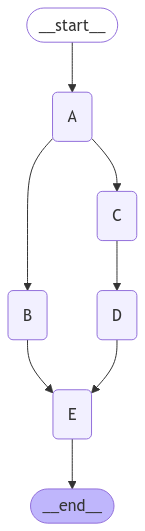

In [4]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
config = {'configurable': {'thread_id': 'foo'}}
graph.invoke(input={'a': []}, config=config)

{'a': ['I am A'],
 'b': ['I am B'],
 'c': ['I am C'],
 'd': ['I am D'],
 'e': ['I am C', 'I am C', 'I am D']}

Expected outcome would have been:

```
{'a': ['I am A'],
 'b': ['I am B'],
 'c': ['I am C'],
 'd': ['I am D'],
 'e': ['I am C', 'I am D']}
```

In [6]:
state = graph.get_state_history(config)

In [7]:
list(state)

[StateSnapshot(values={'a': ['I am A'], 'b': ['I am B'], 'c': ['I am C'], 'd': ['I am D'], 'e': ['I am C', 'I am C', 'I am D']}, next=(), config={'configurable': {'thread_id': 'foo', 'checkpoint_ns': '', 'checkpoint_id': '1efcaec7-f07c-6b50-8004-b2d7949e4800'}}, metadata={'source': 'loop', 'writes': {'E': {'e': ['I am C', 'I am D']}}, 'thread_id': 'foo', 'step': 4, 'parents': {}}, created_at='2025-01-04T22:37:36.408448+00:00', parent_config={'configurable': {'thread_id': 'foo', 'checkpoint_ns': '', 'checkpoint_id': '1efcaec7-f07b-684a-8003-c8fab6f375d3'}}, tasks=()),
 StateSnapshot(values={'a': ['I am A'], 'b': ['I am B'], 'c': ['I am C'], 'd': ['I am D'], 'e': ['I am C']}, next=('E',), config={'configurable': {'thread_id': 'foo', 'checkpoint_ns': '', 'checkpoint_id': '1efcaec7-f07b-684a-8003-c8fab6f375d3'}}, metadata={'source': 'loop', 'writes': {'D': {'d': ['I am D']}, 'E': {'e': ['I am C']}}, 'thread_id': 'foo', 'step': 3, 'parents': {}}, created_at='2025-01-04T22:37:36.407960+00:00

Execution of step ‘E’ is not delayed until the parallel execution of nodes ‘B’, ‘C’, and ‘D’ is fully completed. Instead, ‘E’ is triggered after node ‘B’ finishes and then again after node ‘D’ is executed.

Based on the LangGraph course and the How-to-Guide, I expected a different behavior. Could someone clarify what I misunderstood or did incorrectly?

# System Info

langchain==0.3.8

langchain-community==0.3.8

langchain-core==0.3.28

langchain-fireworks==0.2.6

langchain-openai==0.2.9

langchain-text-splitters==0.3.2

langgraph==0.2.60

langgraph-api==0.0.15

langgraph-checkpoint==2.0.9

langgraph-cli==0.1.65

langgraph-sdk==0.1.48

langsmith==0.1.145